In [1]:
# === Temel Kütüphaneler / Basic Libraries ===
import os                               # Dosya ve klasör işlemleri / File and directory operations
import random                           # Rastgele seçim yapmak için / Random selections
import numpy as np                      # Sayısal işlemler / Numerical computations

# === Görselleştirme / Visualization ===
import matplotlib.pyplot as plt         # Grafik çizimleri / Plotting graphs
import seaborn as sns                   # İstatistiksel grafikler / Statistical visualization
import matplotlib.cm as cm              # Heatmap renklendirme / Colormap for heatmaps

# === TensorFlow & Keras ===
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Veri önişleme & data augmentation / Data preprocessing & augmentation
from tensorflow.keras.utils import load_img, img_to_array            # Görselleri yüklemek ve array'e dönüştürmek / Load images and convert to array
from tensorflow.keras import layers, models                          # Model oluşturmak için temel API / Core API for building models
from tensorflow.keras.callbacks import EarlyStopping                 # Erken durdurma callback / Early stopping callback
from tensorflow.keras.applications import EfficientNetB0             # Transfer Learning için EfficientNetB0 / EfficientNetB0 for transfer learning
from tensorflow.keras.models import Model                            # Grad-CAM için ara katmanlara erişim / Access intermediate layers for Grad-CAM

# === Model Değerlendirme & Dengeleme / Model Evaluation & Balancing ===
from sklearn.utils.class_weight import compute_class_weight          # Sınıf ağırlıklarını dengelemek / Compute class weights

# === Görüntü İşleme (Grad-CAM için) / Image Processing (for Grad-CAM) ===
import cv2                                # Görüntü işleme (OpenCV) / Image processing (OpenCV)

# --- Dataset yolları ---
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir  = "/kaggle/input/intel-image-classification/seg_test/seg_test"

2025-09-26 06:32:55.741918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758868375.773727     273 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758868375.782696     273 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Her sınıftaki dosya sayısını yazdır (Print the number of files in each class)
# Sınıf dengesizliği olup olmadığını anlamamıza yardımcı olur.(Helps us understand if there is any class imbalance)
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        print(f"{class_name}: {num_files} görüntü (image)")


mountain: 2512 görüntü (image)
street: 2382 görüntü (image)
buildings: 2191 görüntü (image)
sea: 2274 görüntü (image)
forest: 2271 görüntü (image)
glacier: 2404 görüntü (image)


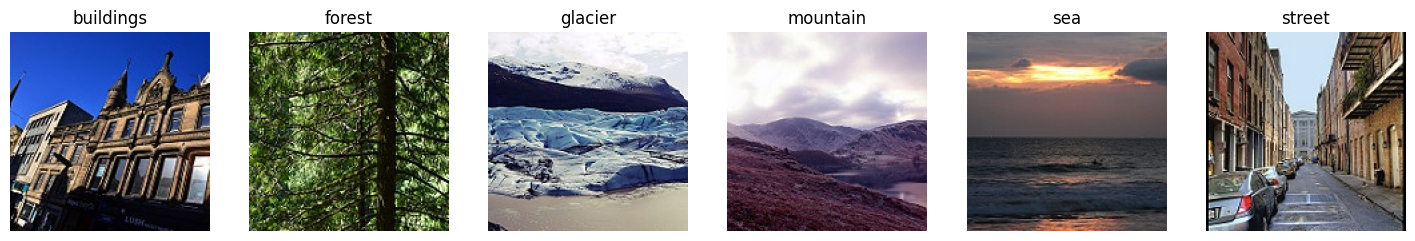

In [3]:


# DATA GÖRSELLEŞTİRME /  VISUALIZE DATASET

train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train" 


labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

plt.figure(figsize=(18,6))


for i, label in enumerate(labels):
    label_dir = os.path.join(train_dir, label)
    # Kategoriden rastgele 1 resim seç / Select 1 random image from the category
    img_file = random.choice(os.listdir(label_dir))
    img_path = os.path.join(label_dir, img_file)
    
    # Resmi yükle ve boyutlandır / Upload and resize image
    img = load_img(img_path, target_size=(150,150))
    
    # Görselleştir / Visualize
    plt.subplot(1,6,i+1)
    plt.imshow(img)
    plt.title(f"{label}")  
    plt.axis('off')

plt.show()


In [4]:

# --- Train Data Augmentation + Normalization ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


# --- Test sadece Normalization ---
test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:

# --- Train & Validation Generator ---
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [6]:

# --- Test Generator ---
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3000 images belonging to 6 classes.


In [7]:

# --- Class indices ---
print("Class indices:", train_generator.class_indices)

Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [8]:
# --- Class weights hesapla ---
classes = list(train_generator.class_indices.values())
y_train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# class_weight kullanarak, az sayıda olan sınıflara daha yüksek ağırlık veriyoruz, böylece model her sınıfa eşit önem verir.
# Using class_weight, we give higher weight to classes that are few in number, so the model gives equal importance to each class.

Class weights: {0: 1.0676934778474996, 1: 1.0300862227114291, 2: 0.9727997227997228, 3: 0.9311774461028193, 4: 1.0283882783882783, 5: 0.9819867086393844}


In [9]:


# --- CNN Modeli ---
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])
# MaxPooling2D: Feature mapleri küçültür, önemli öznitelikleri korur
# MaxPooling2D: Reduces feature maps while keeping important features
# Flatten: 2D feature mapleri 1D vektöre çevirir
# Flatten: Converts 2D feature maps to 1D vector
# Dropout: %50 nöronları rastgele kapatarak overfitting önler
# Dropout: Randomly disables 50% neurons to prevent overfitting

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#optimizer='adam': Ağırlıkları güncellemek için Adam optimizasyon algoritması kullanılır.
#optimizer='adam': The Adam optimization algorithm is used to update the weights.
#loss='categorical_crossentropy': Çok sınıflı sınıflandırma için kayıp fonksiyonu.
#loss='categorical_crossentropy': Loss function for multi-class classification.
#metrics=['accuracy']: Eğitim ve doğrulama sırasında doğruluk metriğini izler.
#metrics=['accuracy']: Monitors the accuracy metric during training and validation.


model.summary()

# --- EarlyStopping ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
#Eğitim sırasında doğrulama kaybı (val_loss) 3 epoch boyunca iyileşmezse eğitimi durdurur.
#During training, if the validation loss (val_loss) does not improve within 3 epochs, it stops training.
#restore_best_weights=True ile model, en iyi doğrulama kaybına sahip ağırlıkları geri yükler.
#With restore_best_weights=True, the model restores the weights with the best validation loss.
#This method is used to prevent overfitting.
#Bu yöntem overfitting’i önlemek için kullanılır.



# ---  Model Eğitimi ---
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

# Modeli kaydet
model.save("model.h5")


#train_generator: Eğitim verilerini besleyen generator.
#train_generator: The generator that feeds the training data.
#validation_data=val_generator: Modeli doğrulama seti ile değerlendirir.
#validation_data=val_generator: Evaluates the model using the validation set.
#class_weight=class_weights_dict: Az sayıda örneğe sahip sınıfların daha yüksek öneme sahip olmasını sağlar.
#class_weight=class_weights_dict: Ensures that classes with fewer examples are given higher importance.
#callbacks=[early_stop]: EarlyStopping kullanılarak aşırı öğrenme önlenir.
#callbacks=[early_stop]: EarlyStopping is used to prevent overfitting.
#epochs=30: Model 30 defa tüm eğitim verisini görecek, ama EarlyStopping ile daha erken durabilir.
#epochs=30: The model will view all the training data 30 times, but EarlyStopping can stop earlier.
#history: Eğitim sırasında kayıp ve doğruluk değerlerini içerir; daha sonra grafik çizimi ve analiz için kullanılabilir.
#history: Contains the loss and accuracy values during training; it can be used for later plotting and analysis.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-26 06:33:05.014550: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 842s 2s/step - accuracy: 0.4178 - loss: 1.4435 - val_accuracy: 0.6049 - val_loss: 0.9788
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 830s 2s/step - accuracy: 0.5905 - loss: 1.0349 - val_accuracy: 0.6623 - val_loss: 0.9056
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 848s 2s/step - accuracy: 0.6470 - loss: 0.9384 - val_accuracy: 0.6883 - val_loss: 0.7982
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 847s 2s/step - accuracy: 0.6810 - loss: 0.8685 - val_accuracy: 0.7364 - val_loss: 0.7498
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 815s 2s/step - accuracy: 0.6960 - loss: 0.8205 - val_accuracy: 0.7325 - val_loss: 0.7244
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 829s 2s/step - accuracy: 0.7208 - loss: 0.7598 - val_accuracy: 0.7493 - val_loss: 0.7045
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.7514 - loss: 0.7073 - val_accuracy: 0.7496 - val_loss: 0.6590
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.7558 - loss: 0.6873 - val_accu

94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 604ms/step


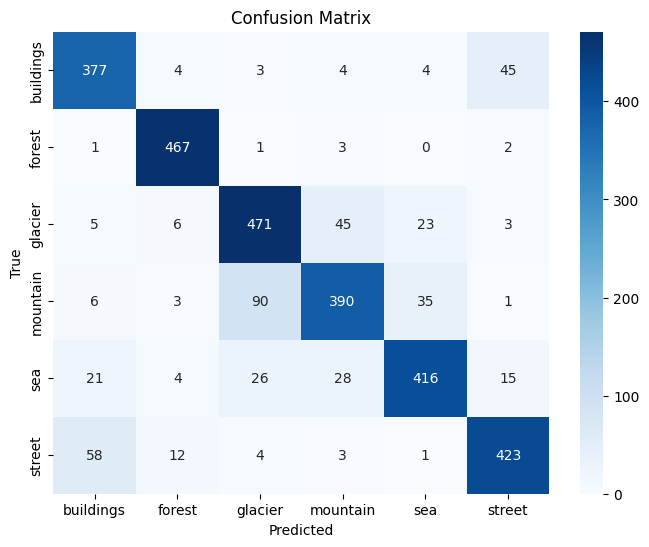

              precision    recall  f1-score   support

   buildings       0.81      0.86      0.83       437
      forest       0.94      0.99      0.96       474
     glacier       0.79      0.85      0.82       553
    mountain       0.82      0.74      0.78       525
         sea       0.87      0.82      0.84       510
      street       0.87      0.84      0.85       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



In [10]:
# --- Test seti tahminleri ---
y_pred = model.predict(test_generator)
# Test verilerini kullanarak modelin tahminlerini al
# Get model predictions using the test data
y_pred_classes = np.argmax(y_pred, axis=1)
# Softmax çıktılarını sınıf indekslerine çevir
# Convert softmax outputs to class indices
y_true = test_generator.classes
# Test verisinin gerçek sınıf etiketleri
# True class labels of the test data

# --- Confusion Matrix ---
cm = tf.math.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()),
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Gerçek ve tahmin edilen sınıflardan confusion matrix oluştur
# Create confusion matrix from true vs predicted classes

# --- Classification Report ---
from sklearn.metrics import classification_report
print(classification_report(
    y_true, y_pred_classes,
    target_names=list(train_generator.class_indices.keys())
))

# Bu rapor precision, recall, f1-score ve support değerlerini verir
# This report provides precision, recall, f1-score, and support for each class

**Confusion Matrix**

Buildings: 377 doğru, ama 45 tanesi yanlışlıkla “street” olarak tahmin edilmiş. Yani “bina” ve “sokak” birbirine karışabiliyor.

Forest: Çok iyi sonuç, 467 doğru. Yanlış tahmin çok az.

Glacier: 471 doğru, ama 45 tane “mountain” ile karışmış → mantıklı çünkü görsel benzerlik yüksek.

Mountain: 390 doğru, ama 90 tane yanlış “glacier” olmuş → yine görsel benzerlik yüzünden.

Sea: 416 doğru, ama 26 tane “glacier” ile karışmış → dalga/kar efekti benzetilmiş olabilir.

Street: 423 doğru, ama 58 tane yanlış “buildings” olmuş.

> Karışıklıklar genellikle benzer görselleri olan sınıflar arasında (ör. dağ ↔ buzul, bina ↔ sokak).

**Classification Report**

Forest (0.96 F1) en iyi sınıf → model için en kolay ayırt edilen sınıf.

Glacier (0.82 F1) ve Mountain (0.78 F1) en zayıf sınıflar → karışma en çok burada.

Diğer sınıflar (“Buildings, Sea, Street”) ortalama 0.83–0.85 civarında.

Genel Performans - - -> Accuracy = %85

Macro avg, Weighted avg da %85 → dataset dengeli ve model her sınıfta benzer performans gösteriyor.

> Modelin genel başarısı yüksek (%85). Orman sınıfında neredeyse kusursuz, ama dağ–buzul ve bina–sokak sınıflarında karışıklıklar performansı biraz düşürüyor.

**Confusion Matrix**

Buildings: 377 correct, but 45 were mistakenly predicted as “street.” This shows that “buildings” and “street” can be confused.

Forest: Very good result, 467 correct. Very few misclassifications.

Glacier: 471 correct, but 45 were misclassified as “mountain” → reasonable since the visual similarity is high.

Mountain: 390 correct, but 90 were misclassified as “glacier” → again due to visual similarity.

Sea: 416 correct, but 26 were confused with “glacier” → possibly because wave patterns resemble snow/ice.

Street: 423 correct, but 58 were misclassified as “buildings.”

> Misclassifications mostly occur between classes with visually similar features (e.g., mountain ↔ glacier, building ↔ street).

---

**Classification Report**

Forest (0.96 F1) is the best-performing class → the easiest for the model to distinguish.

Glacier (0.82 F1) and Mountain (0.78 F1) are the weakest classes → most confusion occurs here.

Other classes (“Buildings, Sea, Street”) are around 0.83–0.85.

Overall Performance → Accuracy = **85%**

Macro avg and Weighted avg are also 85% → the dataset is balanced, and the model performs consistently across classes.

> The model’s overall performance is strong (85%). The forest class is nearly flawless, but confusion between mountain–glacier and building–street slightly reduces performance.


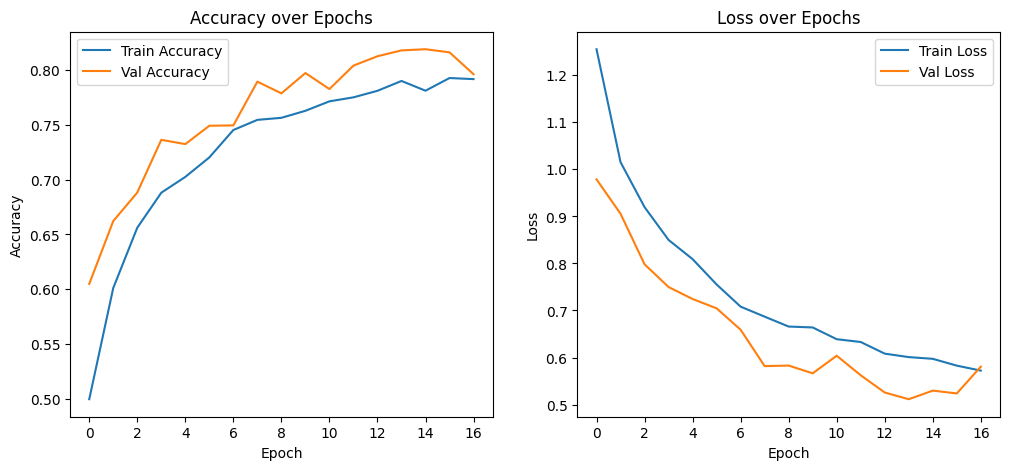

In [11]:
# --- Accuracy ve Loss grafikleri ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


**Accuracy ve Loss Grafikleri**

Accuracy Grafiği (Solda)

Validation accuracy, training accuracy’den genelde biraz daha yüksek. Bu, modelin aşırı öğrenmediğini (overfitting) ve iyi genelleştirdiğini gösteriyor.

Loss Grafiği (Sağda)

Validation loss ile train loss birbirine yakın, arada büyük fark yok. Bu da modelin overfitting yapmadığını gösteriyor.

> Model iyi öğrenmiş, hem eğitim hem validasyon performansı uyumlu, genelleme kabiliyeti yüksek.

**Accuracy and Loss Graphs**

Accuracy Graph (Left)

Validation accuracy is generally slightly higher than training accuracy. This indicates that the model is not overfitting and is generalizing well.

Loss Graph (Right)

Validation loss and training loss are close to each other, with no significant gap. This also shows that the model is not overfitting.

> The model has learned well, with both training and validation performance being consistent, demonstrating strong generalization capability.

Found 3000 images belonging to 6 classes.


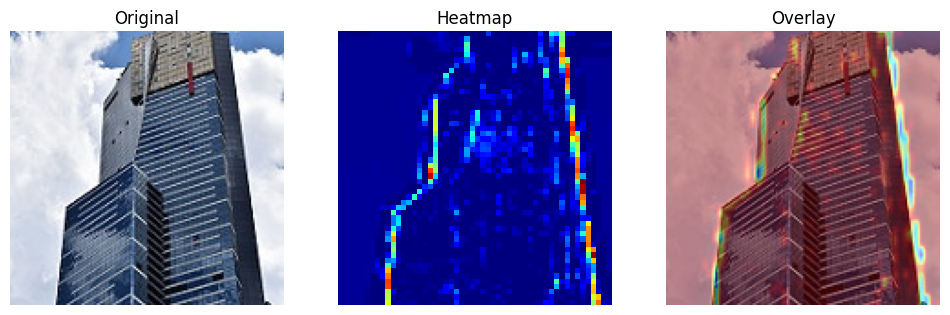

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2

# --- Modeli yükle ---
model = load_model("model.h5")

# --- Test veri generator ---
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/intel-image-classification/seg_test/seg_test",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# --- Görüntüyü array haline getir ---
def get_img_array(img_path, size=(224,224)):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0

# --- Grad-CAM fonksiyonu (Sequential uyumlu) ---
def make_gradcam_heatmap_seq(img_array, model):
    # Son conv katmanı bul
    last_conv_index = None
    for i in reversed(range(len(model.layers))):
        if 'conv' in model.layers[i].name:
            last_conv_index = i
            break
    if last_conv_index is None:
        raise ValueError("Conv2D katmanı bulunamadı.")

    # Sequential katmanlarıyla manuel ilerleme
    x = img_array
    conv_output = None
    for i, layer in enumerate(model.layers):
        x = layer(x)
        if i == last_conv_index:
            conv_output = x

    # GradientTape ile gradyan hesapla
    with tf.GradientTape() as tape:
        tape.watch(conv_output)
        # conv_output'tan devam ederek tahmini hesapla
        y = conv_output
        for layer in model.layers[last_conv_index+1:]:
            y = layer(y)
        pred_index = tf.argmax(y[0])
        class_channel = y[:, pred_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- Örnek kullanım ---
img_path = test_generator.filepaths[0]
img_array = get_img_array(img_path)
heatmap = make_gradcam_heatmap_seq(img_array, model)

# --- Görselleştirme ---
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Heatmap")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(superimposed_img)
plt.title("Overlay")
plt.axis("off")
plt.show()


**Heatmap (Grad-CAM benzeri görselleştirme)**

Original: Binanın orijinal fotoğrafı.

Heatmap: Modelin sınıflandırmada dikkate aldığı bölgeleri gösteriyor.

Overlay: Orijinal görüntü ile heatmap’in üst üste bindirilmiş hali.

> Model binanın kenarları ve yapısal hatlarına daha fazla odaklanmış. Bu da modelin doğru sınıflandırmada gerçekten “binayı temsil eden kısımları” kullandığını gösteriyor.


**Heatmap (Grad-CAM-like visualization)**

Original: The original photo of the building.

Heatmap: Shows the regions the model focused on during classification.

Overlay: The original image combined with the heatmap.

> The model focused more on the edges and structural lines of the building. This indicates that the model is indeed using the parts that represent the building for correct classification.